# YOLOv8x
## ("x" Extra-Large: Highest accuracy, slow)
### Detection, tracking, and IOU Scores for 300 Frames of VIRAT Ground Video
- 5 Vehicles
- 3 Persons

## 1. Data Import

In [1]:
!python --version

Python 3.10.12


In [2]:
import pandas as pd
import numpy as np
import torch

In [3]:
# upload sample file: 'VIRAT_S_000200_03_000657_000899_first300.mp4'
# this is the first 300 frames of 'VIRAT_S_000200_03_000657_000899.mp4'
# viewable at: https://drive.google.com/file/d/1C-HPOEIdZnJm_RSbYGXH6gMLhlmobaxn/view?usp=drive_link

!gdown "https://drive.google.com/uc?id=1C-HPOEIdZnJm_RSbYGXH6gMLhlmobaxn" -O test.mp4

Downloading...
From: https://drive.google.com/uc?id=1C-HPOEIdZnJm_RSbYGXH6gMLhlmobaxn
To: /content/test.mp4
100% 10.4M/10.4M [00:00<00:00, 66.0MB/s]


I used `ffmpeg -i VIRAT_S_000200_03_000657_000899.mp4 -c:v copy -frames:v 300 -r 30 -an ~/Desktop/VIRAT_S_000200_03_000657_000899_first300.mp4` to create cut the first 300 frames of this video to a clip



In [4]:
# display details of clip
!ffprobe -v quiet -print_format json -show_format -show_streams test.mp4

{
    "streams": [
        {
            "index": 0,
            "codec_name": "mpeg4",
            "codec_long_name": "MPEG-4 part 2",
            "profile": "Simple Profile",
            "codec_type": "video",
            "codec_time_base": "1/30",
            "codec_tag_string": "mp4v",
            "codec_tag": "0x7634706d",
            "width": 1280,
            "height": 720,
            "coded_width": 1280,
            "coded_height": 720,
            "has_b_frames": 0,
            "sample_aspect_ratio": "1:1",
            "display_aspect_ratio": "16:9",
            "pix_fmt": "yuv420p",
            "level": 3,
            "color_range": "tv",
            "color_space": "bt709",
            "color_transfer": "bt709",
            "color_primaries": "bt709",
            "chroma_location": "left",
            "refs": 1,
            "quarter_sample": "false",
            "divx_packed": "false",
            "r_frame_rate": "30/1",
            "avg_frame_rate": "30/1",
            "tim

In [5]:
!ls -lh

total 10M
drwxr-xr-x 1 root root 4.0K Jun 26 13:35 sample_data
-rw-r--r-- 1 root root  10M Jun 27 19:00 test.mp4


## 2. Ground Truth

- Data from https://gitlab.kitware.com/viratdata/viratannotations
- obtain the ground truth bounding boxes data
- store in Pandas DataFrame 'gtdf'

In [6]:
# VIRAT_S_000200_03_000657_000899.types.yml
!gdown "https://drive.google.com/uc?id=12h_35hXzoSciduBzDWmpKB2-rgUuraiN" -O test.types.yml

Downloading...
From: https://drive.google.com/uc?id=12h_35hXzoSciduBzDWmpKB2-rgUuraiN
To: /content/test.types.yml
100% 2.71k/2.71k [00:00<00:00, 14.0MB/s]


In [7]:
# VIRAT_S_000200_03_000657_000899.regions.yml
!gdown "https://drive.google.com/uc?id=1Ieau47ZxLLpE6mw04XwjfANeQPB9m7hY" -O test.regions.yml

Downloading...
From: https://drive.google.com/uc?id=1Ieau47ZxLLpE6mw04XwjfANeQPB9m7hY
To: /content/test.regions.yml
100% 12.6M/12.6M [00:00<00:00, 128MB/s]


In [8]:
# VIRAT_S_000200_03_000657_000899.geom.yml
!gdown "https://drive.google.com/uc?id=1UH9s2MPSZFdJJ7TD827DrmqGPtR_CWdQ" -O test.geom.yml

Downloading...
From: https://drive.google.com/uc?id=1UH9s2MPSZFdJJ7TD827DrmqGPtR_CWdQ
To: /content/test.geom.yml
100% 8.54M/8.54M [00:00<00:00, 164MB/s]


In [9]:
# VIRAT_S_000200_03_000657_000899.activities.yml
!gdown "https://drive.google.com/uc?id=1tTAnWLE5f9FhbWCe4vElR7gD9aK0jYin" -O test.activities.yml

Downloading...
From: https://drive.google.com/uc?id=1tTAnWLE5f9FhbWCe4vElR7gD9aK0jYin
To: /content/test.activities.yml
100% 14.3k/14.3k [00:00<00:00, 51.4MB/s]


In [10]:
!ls -lh

total 31M
drwxr-xr-x 1 root root 4.0K Jun 26 13:35 sample_data
-rw-r--r-- 1 root root  14K Jun 27 19:00 test.activities.yml
-rw-r--r-- 1 root root 8.2M Jun 27 19:00 test.geom.yml
-rw-r--r-- 1 root root  10M Jun 27 19:00 test.mp4
-rw-r--r-- 1 root root  12M Jun 27 19:00 test.regions.yml
-rw-r--r-- 1 root root 2.7K Jun 27 19:00 test.types.yml


In [11]:
# get bounding boxes, classes and track ids for detections in all 300 frames of video
import yaml

file_path = 'test.geom.yml'
with open(file_path, 'r') as file:
    geom = yaml.safe_load(file)
file_path = 'test.types.yml'
with open(file_path, 'r') as file:
    types = yaml.safe_load(file)

### Create Ground Truth DataFrame

AS pd.DataFrame </br>
format: </br>
{idx: geom_id0, </br>
track_id: geom_id1, </br>
label: types_cset3-key_on_id1, </br>
conf: types_cset3-value_on_id1, </br>
frame: geom_ts0, </br>
xmin: geom_g0.split(' ')[0], ymin: geom_g0.split(' ')[1], xmax: geom_g0.split(' ')[2], ymax: geom_g0.split(' ')[3]}

In [12]:
detections = []

# lists for populating dictionary then DataFrame
idx = []
track_id = []
labels = []
labels_ints = []
confs = []
frame = []
xmin, ymin, xmax, ymax = [], [], [], []

for i in geom:
  try:
    if i['geom']['ts0'] < 300:  # populates detections data from first 300 frames
      detections.append(i)
      idx.append(i['geom']['id0'])
      track_id.append(i['geom']['id1'])
      frame.append(i['geom']['ts0'])
      bb = i['geom']['g0'].split(' ')
      xmin.append(int(bb[0]))
      ymin.append(int(bb[1]))
      xmax.append(int(bb[2]))
      ymax.append(int(bb[3]))

      for j in types:
        try:
          if j['types']['id1'] == track_id[-1]:  # pulls labels and confidences (by track id --> 'id1') from types.yaml file
            label, conf = next(iter(j['types']['cset3'].items()))
            confs.append(conf)
            labels.append(label)
            # also save labels as ints for comparison with YOLOv8 Predictions later on
            if label == 'Person':
              labels_ints.append(0)
            elif label == 'Bike':
              labels_ints.append(1)
            elif label == 'Vehicle':
              labels_ints.append(2)
            else:
              labels_ints.append(-1)
        except:
          pass
  except:
    pass

print('idx: ', len(idx),
      'track_id: ', len(track_id),
      'label: ', len(labels),
      'conf: ', len(confs),
      'frame: ', len(frame))


gt = {'idx_gt': idx, 'track_id_gt': track_id, 'label_gt': labels,
      'label_as_int_gt': labels_ints, 'conf_gt': confs, 'frame_gt': frame,
      'xmin_gt': xmin, 'ymin_gt': ymin, 'xmax_gt': xmax, 'ymax_gt': ymax}
df_gt = pd.DataFrame(gt)
df_gt

idx:  3406 track_id:  3406 label:  3406 conf:  3406 frame:  3406


,idx_gt,track_id_gt,label_gt,label_as_int_gt,conf_gt,frame_gt,xmin_gt,ymin_gt,xmax_gt,ymax_gt
0,0,1,Vehicle,2,1.0,0,946,327,1010,360
1,1,1,Vehicle,2,1.0,1,945,326,1009,359
2,2,1,Vehicle,2,1.0,2,945,326,1009,359
3,3,1,Vehicle,2,1.0,3,945,326,1009,359
4,4,1,Vehicle,2,1.0,4,945,326,1009,359
...,...,...,...,...,...,...,...,...,...,...
3401,73049,5030,Door,-1,1.0,295,72,423,95,487
3402,73050,5030,Door,-1,1.0,296,72,423,95,487
3403,73051,5030,Door,-1,1.0,297,72,423,95,487
3404,73052,5030,Door,-1,1.0,298,72,423,95,487


## Let's drop all detections besides Cars, People, and Bikes

In [13]:
df_gt = df_gt[df_gt['label_as_int_gt'] != -1]
df_gt.groupby('label_as_int_gt').count()

,idx_gt,track_id_gt,label_gt,conf_gt,frame_gt,xmin_gt,ymin_gt,xmax_gt,ymax_gt
label_as_int_gt,,,,,,,,,
0,900,900,900,900,900,900,900,900,900
2,1306,1306,1306,1306,1306,1306,1306,1306,1306


In [14]:
df_gt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idx_gt           2206 non-null   int64  
 1   track_id_gt      2206 non-null   int64  
 2   label_gt         2206 non-null   object 
 3   label_as_int_gt  2206 non-null   int64  
 4   conf_gt          2206 non-null   float64
 5   frame_gt         2206 non-null   int64  
 6   xmin_gt          2206 non-null   int64  
 7   ymin_gt          2206 non-null   int64  
 8   xmax_gt          2206 non-null   int64  
 9   ymax_gt          2206 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 189.6+ KB


## 3. Get Predictions
- get inference from YOLOv8 with ByteTracker on this test clip
- store predictions in Pandas DataFrame 'preddf'

Install YOLOv8

In [15]:
!pip -q install ultralytics
!pip -q install lap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### YOLOv8x model -- 'x': "Extra-Large"

In [16]:
from ultralytics import YOLO
import lap

model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 145MB/s]


In [17]:
%%time
results = model.track(source='/content/test.mp4', conf=0.12, iou=0.5,
                      device=0, save_txt=True, imgsz=1280, classes=[0,1,2],
                      tracker="bytetrack.yaml", stream=True)
list_results = list(results)


video 1/1 (1/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 116.3ms
video 1/1 (2/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 112.9ms
video 1/1 (3/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.5ms
video 1/1 (4/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 116.8ms
video 1/1 (5/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.3ms
video 1/1 (6/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.4ms
video 1/1 (7/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.3ms
video 1/1 (8/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 117.1ms
video 1/1 (9/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 116.1ms
video 1/1 (10/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.4ms
video 1/1 (11/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.4ms
video 1/1 (12/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 115.6ms
video 1/1 (13/300) /content/test.mp4: 736x1280 3 persons, 5 cars, 117.6ms
video 1/1 (14/300) /content/test.mp4: 736x1280

CPU times: user 49.2 s, sys: 3.14 s, total: 52.4 s
Wall time: 1min 9s


With `save_txt = True`, .txt files are in format `class_label xmid_ratio ymid_ratio width height track_id`

In [18]:
# frame 1 detections as .txt file(s)
!cat runs/detect/track/labels/test_1.txt

2 0.567938 0.73391 0.113069 0.0800446 1
2 0.138408 0.552926 0.0959476 0.0557588 2
2 0.123771 0.511683 0.0844023 0.0427548 3
2 0.763959 0.478846 0.0478971 0.0368395 4
2 0.751314 0.962322 0.0916481 0.0746406 5
0 0.58139 0.57572 0.0151847 0.0568068 6
0 0.910461 0.945289 0.0211571 0.0960363 7
0 0.232387 0.759373 0.0209226 0.0802561 8


A better way:</br>
ultralytics.yolo.engine.results.Boxes attribute formats:
- Boxes.data use [xmin, ymin, xmax, ymax, track_id, conf, class]

In [19]:
list_results[0].boxes.data

tensor([[6.5460e+02, 4.9960e+02, 7.9932e+02, 5.5723e+02, 1.0000e+00, 9.1789e-01, 2.0000e+00],
        [1.1576e+02, 3.7803e+02, 2.3857e+02, 4.1818e+02, 2.0000e+00, 9.0728e-01, 2.0000e+00],
        [1.0441e+02, 3.5302e+02, 2.1244e+02, 3.8380e+02, 3.0000e+00, 8.6848e-01, 2.0000e+00],
        [9.4721e+02, 3.3151e+02, 1.0085e+03, 3.5803e+02, 4.0000e+00, 8.6517e-01, 2.0000e+00],
        [9.0303e+02, 6.6600e+02, 1.0203e+03, 7.1974e+02, 5.0000e+00, 8.4081e-01, 2.0000e+00],
        [7.3446e+02, 3.9407e+02, 7.5390e+02, 4.3497e+02, 6.0000e+00, 7.9617e-01, 0.0000e+00],
        [1.1518e+03, 6.4604e+02, 1.1789e+03, 7.1518e+02, 7.0000e+00, 7.8754e-01, 0.0000e+00],
        [2.8407e+02, 5.1786e+02, 3.1085e+02, 5.7564e+02, 8.0000e+00, 6.5013e-01, 0.0000e+00]])

### Create DataFrame for predictions

In [20]:
len(list_results[0].boxes.data)

8

In [21]:
# Create dictionary of predictions `df_pred

track_id = []
label = []
conf = []
frame = []
xmin, ymin, xmax, ymax = [], [], [], []

for i in range(len(list_results)):  # loop through all frames
  for j in range(len(list_results[i].boxes.data)):  # loop through all detections per frame
    bb = [torch.round(k) for k in iter(list_results[i].boxes.data[j])]  # enumerate data per detection: [xmin, ymin, xmax, ymax, track_id, conf, class]
    xmin.append(int(bb[0]))
    ymin.append(int(bb[1]))
    xmax.append(int(bb[2]))
    ymax.append(int(bb[3]))
    track_id.append(int(bb[4]))
    conf.append(int(bb[5]))
    label.append(int(bb[6]))
    frame.append(i)  # frames in gt start from 0

pred = {'track_id_pred': track_id, 'label_pred': label, 'conf_pred': conf, 'frame_pred': frame, 'xmin_pred': xmin, 'ymin_pred': ymin, 'xmax_pred': xmax, 'ymax_pred': ymax}

df_pred = pd.DataFrame(pred)
df_pred.head()

,track_id_pred,label_pred,conf_pred,frame_pred,xmin_pred,ymin_pred,xmax_pred,ymax_pred
0,1,2,1,0,655,500,799,557
1,2,2,1,0,116,378,239,418
2,3,2,1,0,104,353,212,384
3,4,2,1,0,947,332,1009,358
4,5,2,1,0,903,666,1020,720


In [22]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   track_id_pred  2197 non-null   int64
 1   label_pred     2197 non-null   int64
 2   conf_pred      2197 non-null   int64
 3   frame_pred     2197 non-null   int64
 4   xmin_pred      2197 non-null   int64
 5   ymin_pred      2197 non-null   int64
 6   xmax_pred      2197 non-null   int64
 7   ymax_pred      2197 non-null   int64
dtypes: int64(8)
memory usage: 137.4 KB


## Compare/Contrast dataframes

How many track_ids?

In [23]:
# ground truth
df_gt.groupby('track_id_gt').count()

,idx_gt,label_gt,label_as_int_gt,conf_gt,frame_gt,xmin_gt,ymin_gt,xmax_gt,ymax_gt
track_id_gt,,,,,,,,,
1,300,300,300,300,300,300,300,300,300
2,300,300,300,300,300,300,300,300,300
3,300,300,300,300,300,300,300,300,300
4,300,300,300,300,300,300,300,300,300
5,106,106,106,106,106,106,106,106,106
33,300,300,300,300,300,300,300,300,300
34,300,300,300,300,300,300,300,300,300
35,300,300,300,300,300,300,300,300,300


In [24]:
# predicted
df_pred.groupby('track_id_pred').count()

,label_pred,conf_pred,frame_pred,xmin_pred,ymin_pred,xmax_pred,ymax_pred
track_id_pred,,,,,,,
1,300,300,300,300,300,300,300
2,300,300,300,300,300,300,300
3,300,300,300,300,300,300,300
4,300,300,300,300,300,300,300
5,97,97,97,97,97,97,97
6,300,300,300,300,300,300,300
7,300,300,300,300,300,300,300
8,300,300,300,300,300,300,300


## Get IOU scores for each frame & object of video

In [25]:
def get_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    boxA -- [xmin, ymin, xmax, ymax] of box A
    boxB -- [xmin, ymin, xmax, ymax] of box B

    Returns:
    iou   -- Intersection over Union
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [26]:
# Create a cross join dataframe
df_gt['key'] = 1
df_pred['key'] = 1
df_cross = pd.merge(df_gt, df_pred, left_on=['key', 'frame_gt'], right_on=['key', 'frame_pred']).drop("key", axis=1)

<ipython-input-26-5e785a50da87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gt['key'] = 1


In [27]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16218 entries, 0 to 16217
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idx_gt           16218 non-null  int64  
 1   track_id_gt      16218 non-null  int64  
 2   label_gt         16218 non-null  object 
 3   label_as_int_gt  16218 non-null  int64  
 4   conf_gt          16218 non-null  float64
 5   frame_gt         16218 non-null  int64  
 6   xmin_gt          16218 non-null  int64  
 7   ymin_gt          16218 non-null  int64  
 8   xmax_gt          16218 non-null  int64  
 9   ymax_gt          16218 non-null  int64  
 10  track_id_pred    16218 non-null  int64  
 11  label_pred       16218 non-null  int64  
 12  conf_pred        16218 non-null  int64  
 13  frame_pred       16218 non-null  int64  
 14  xmin_pred        16218 non-null  int64  
 15  ymin_pred        16218 non-null  int64  
 16  xmax_pred        16218 non-null  int64  
 17  ymax_pred   

In [28]:
%%time

# Calculate IOU for each pair
df_cross['iou'] = df_cross.apply(lambda row: get_iou(row[['xmin_gt', 'ymin_gt', 'xmax_gt', 'ymax_gt']], row[['xmin_pred', 'ymin_pred', 'xmax_pred', 'ymax_pred']]), axis=1)

# Find the pairs with maximum IOU for each ground truth bounding box
df_matched = df_cross.loc[df_cross.groupby(['idx_gt'])['iou'].idxmax()]

CPU times: user 17 s, sys: 69.7 ms, total: 17.1 s
Wall time: 18.2 s


In [29]:
df_matched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 3 to 16216
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idx_gt           2206 non-null   int64  
 1   track_id_gt      2206 non-null   int64  
 2   label_gt         2206 non-null   object 
 3   label_as_int_gt  2206 non-null   int64  
 4   conf_gt          2206 non-null   float64
 5   frame_gt         2206 non-null   int64  
 6   xmin_gt          2206 non-null   int64  
 7   ymin_gt          2206 non-null   int64  
 8   xmax_gt          2206 non-null   int64  
 9   ymax_gt          2206 non-null   int64  
 10  track_id_pred    2206 non-null   int64  
 11  label_pred       2206 non-null   int64  
 12  conf_pred        2206 non-null   int64  
 13  frame_pred       2206 non-null   int64  
 14  xmin_pred        2206 non-null   int64  
 15  ymin_pred        2206 non-null   int64  
 16  xmax_pred        2206 non-null   int64  
 17  ymax_pred    

In [30]:
# How many missed predictions? ie ground truth box exists but no prediction box was given
df_matched[df_matched['iou']<.01].count()

idx_gt             9
track_id_gt        9
label_gt           9
label_as_int_gt    9
conf_gt            9
frame_gt           9
xmin_gt            9
ymin_gt            9
xmax_gt            9
ymax_gt            9
track_id_pred      9
label_pred         9
conf_pred          9
frame_pred         9
xmin_pred          9
ymin_pred          9
xmax_pred          9
ymax_pred          9
iou                9
dtype: int64

In [31]:
len(df_gt) - len(df_pred)

9

In [32]:
df_matched[df_matched['iou']<.01]

,idx_gt,track_id_gt,label_gt,label_as_int_gt,conf_gt,frame_gt,xmin_gt,ymin_gt,xmax_gt,ymax_gt,track_id_pred,label_pred,conf_pred,frame_pred,xmin_pred,ymin_pred,xmax_pred,ymax_pred,iou
3932,29033,5,Vehicle,2,1.0,61,1114,525,1196,585,1,2,1,61,655,500,799,557,0.0
3988,29034,5,Vehicle,2,1.0,62,1117,523,1198,583,1,2,1,62,655,500,799,557,0.0
4044,29035,5,Vehicle,2,1.0,63,1120,521,1200,581,1,2,1,63,655,500,799,557,0.0
4100,29036,5,Vehicle,2,1.0,64,1123,519,1203,579,1,2,1,64,655,500,799,557,0.0
6460,29073,5,Vehicle,2,1.0,101,1211,471,1262,509,1,2,1,101,655,500,799,557,0.0
6516,29074,5,Vehicle,2,1.0,102,1213,471,1262,506,1,2,1,102,654,500,799,557,0.0
6572,29075,5,Vehicle,2,1.0,103,1215,472,1262,504,1,2,1,103,654,500,799,557,0.0
6628,29076,5,Vehicle,2,1.0,104,1218,473,1262,502,1,2,1,104,655,500,799,557,0.0
6684,29077,5,Vehicle,2,1.0,105,1223,477,1268,506,1,2,1,105,655,500,799,557,0.0


In [33]:
df_matched

,idx_gt,track_id_gt,label_gt,label_as_int_gt,conf_gt,frame_gt,xmin_gt,ymin_gt,xmax_gt,ymax_gt,track_id_pred,label_pred,conf_pred,frame_pred,xmin_pred,ymin_pred,xmax_pred,ymax_pred,iou
3,0,1,Vehicle,2,1.0,0,946,327,1010,360,4,2,1,0,947,332,1009,358,0.769683
67,1,1,Vehicle,2,1.0,1,945,326,1009,359,4,2,1,1,947,331,1008,358,0.785520
131,2,1,Vehicle,2,1.0,2,945,326,1009,359,4,2,1,2,947,331,1008,358,0.785520
195,3,1,Vehicle,2,1.0,3,945,326,1009,359,4,2,1,3,947,332,1009,358,0.769683
259,4,1,Vehicle,2,1.0,4,945,326,1009,359,4,2,1,4,948,332,1008,358,0.745249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16020,46534,35,Person,0,1.0,295,1192,575,1240,639,7,0,1,295,1197,577,1225,636,0.546311
16069,46535,35,Person,0,1.0,296,1192,575,1240,639,7,0,1,296,1197,577,1225,636,0.546311
16118,46536,35,Person,0,1.0,297,1192,575,1240,639,7,0,1,297,1198,577,1226,636,0.546311
16167,46537,35,Person,0,1.0,298,1192,575,1240,639,7,0,1,298,1198,577,1226,636,0.546311


In [34]:
df_matched.describe()

,idx_gt,track_id_gt,label_as_int_gt,conf_gt,frame_gt,xmin_gt,ymin_gt,xmax_gt,ymax_gt,track_id_pred,label_pred,conf_pred,frame_pred,xmin_pred,ymin_pred,xmax_pred,ymax_pred,iou
count,2206.000000,2206.000000,2206.000000,2206.0,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.00000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000
mean,23867.247053,15.471442,1.184044,1.0,144.839075,611.516319,440.395286,690.878513,491.404352,4.439710,1.184044,0.99864,144.839075,614.059383,444.377607,686.161831,489.887579,0.719260
std,15723.507103,15.424598,0.983141,0.0,87.283254,403.081605,96.108346,384.374472,109.153721,2.395336,0.983141,0.03686,87.283254,401.925824,96.033258,382.633558,108.993170,0.154110
min,0.000000,1.000000,0.000000,1.0,0.000000,102.000000,326.000000,212.000000,359.000000,1.000000,0.000000,0.00000,0.000000,104.000000,331.000000,212.000000,358.000000,0.000000
25%,7494.250000,2.000000,0.000000,1.0,68.250000,114.000000,349.000000,237.000000,386.000000,2.000000,0.000000,1.00000,68.250000,116.000000,353.000000,238.000000,384.000000,0.599034
50%,21931.500000,4.000000,2.000000,1.0,142.000000,647.000000,389.000000,801.000000,434.000000,4.000000,2.000000,1.00000,142.000000,655.000000,393.000000,799.000000,433.000000,0.798190
75%,39641.750000,34.000000,2.000000,1.0,221.000000,945.000000,516.000000,1009.000000,577.000000,7.000000,2.000000,1.00000,221.000000,947.000000,518.000000,1009.000000,576.000000,0.834739
max,46538.000000,35.000000,2.000000,1.0,299.000000,1223.000000,659.000000,1268.000000,718.000000,8.000000,2.000000,1.00000,299.000000,1217.000000,666.000000,1256.000000,720.000000,0.918890


### IOU Scores averaged for all 300 frames
- for all detections collectively
- per object individually

In [35]:
print('average IOU for all detections across the 300 frames')
df_matched['iou'].mean()

average IOU for all detections across the 300 frames


0.7192596050267219

In [36]:
print('average IOU for each distinct object')
df_matched.groupby('track_id_gt')[['label_as_int_gt', 'iou']].mean()

average IOU for each distinct object


,label_as_int_gt,iou
track_id_gt,,
1,2.0,0.786959
2,2.0,0.838288
3,2.0,0.894767
4,2.0,0.823948
5,2.0,0.727549
33,0.0,0.494400
34,0.0,0.596079
35,0.0,0.597446


In [37]:
print('the People on average had the worst IOU scores')
print('the Vehicles did very well, \nexcept for the one vehicle which is moving and disappears behind tree branches. \nThe detection model missed the last 25 frames of \nground truth for this. \nPartial Occlusion appears to be an issue.')

the People on average had the worst IOU scores
the Vehicles did very well, 
except for the one vehicle which is moving and disappears behind tree branches. 
The detection model missed the last 25 frames of 
ground truth for this. 
Partial Occlusion appears to be an issue.


# Compare these results to the 'nano' model YOLOv8n
### 'Extra-large' model does not do much better. Overall average IOU dropped. Two detection IOU scores dropped.

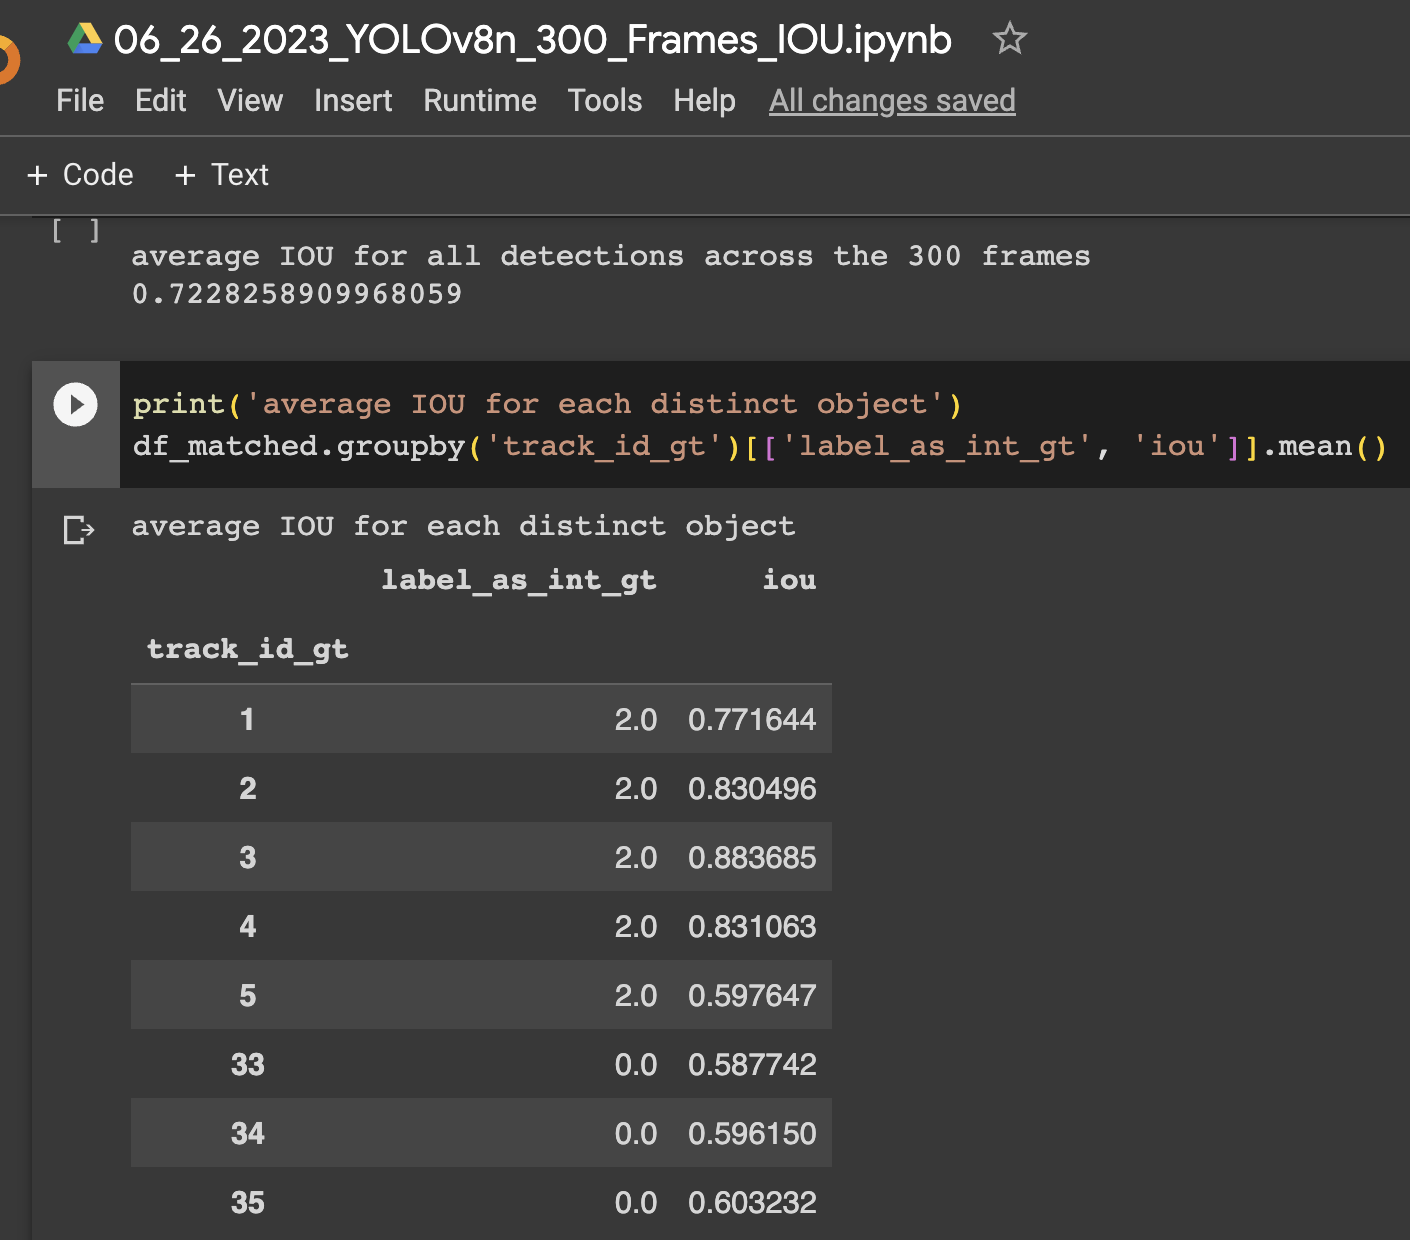